### osu!nn #4: Slider classifier

The original aim of this classifier was to classify the length of sliders, and where slider ends, potentially slider shapes. However, it is currently unused.

It turns out to be completely inaccurate - perhaps it's because I was testing with Sota music, or perhaps sliders are actually mapper creativity and irrelevant to music itself.

Synthesis of "sliderModel"
* audioData x 1
* timingData x 1
* sliderLabels x 1
* (Classifier) x 2

Synthesis Time: ~8 mins

Last edit: 2018/8/16

Import the wheels. By the way pandas is not used, re is also not. For future expansion of course!

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re

In [2]:
root = ".\\mapdata";

divisor = 4;

max_x = 512;
max_y = 384;

In [3]:
# lst file, [TICK, TIME, NOTE, IS_CIRCLE, IS_SLIDER, IS_SPINNER, IS_SLIDER_END, IS_SPINNER_END, 
#               0,    1,    2,         3,         4,          5,             6,              7,
#            SLIDING, SPINNING, MOMENTUM, ANGULAR_MOMENTUM, EX1, EX2, EX3], length MAPTICKS
#                  8,        9,       10,               11,  12,  13,  14,
# wav file, [len(snapsize), MAPTICKS, 2, fft_size//4]
def read_npz(fn):
    with np.load(fn) as data:
        wav_data = data["wav"];
        wav_data = np.swapaxes(wav_data, 2, 3);
        train_data = wav_data;
        div_source = data["lst"][:, 0];
        div_source2 = data["lst"][:, 12:15];
        div_data = np.concatenate([np.array([[int(k%4==0), int(k%4==1), int(k%4==2), int(k%4==3)] for k in div_source]), div_source2], axis=1);
        lst_data = data["lst"][:, [0, 2, 3, 4, 5, 6, 8]];
        # this time there is no 2*k-1!
        train_labels = lst_data;
    return train_data, div_data, train_labels;

def read_all_npzs():
    td_list = [];
    dd_list = [];
    tl_list = [];
    for file in os.listdir(root):
        if file.endswith(".npz"):
            _td, _dd, _tl = read_npz(os.path.join(root, file));
            td_list.append(_td);
            dd_list.append(_dd);
            tl_list.append(_tl);
    train_data = np.concatenate(td_list);
    div_data = np.concatenate(dd_list);
    train_labels = np.concatenate(tl_list);
    
    # should be (X, 7, 32, 2) and (X, 6) in default sampling settings
    # (X, fft_window_type, freq_point, magnitude/phase)
    # X = 76255
    # print(train_data.shape, train_labels.shape);
    return train_data, div_data, train_labels;
                
(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered) = read_all_npzs();

In [4]:
# print(np.sum(slider_length_labels[:, 0]))
# print(np.sum(slider_length_labels[:, 1]))
# print(np.sum(slider_length_labels[:, 2]))
# print(np.sum(slider_length_labels[:, 3]))
# print(np.sum(slider_length_labels[:, 4]))

In [19]:


# Before: TICK, NOTE, IS_CIRCLE, IS_SLIDER, IS_SPINNER, IS_SLIDER_END, SLIDING
#            0,    1,         2,         3,          4,             5,       6

temp_train_data = [];
temp_div_data = [];
temp_train_labels = [];

filter_index_list = [];
slider_index_list = [];
slider_length_list = [];
append_flag = False;
current_slider_tick = 0;
is_sliding = False;

for i,k in enumerate(train_labels_unfiltered):
    if k[0] < current_slider_tick:
        current_slider_tick = 0;
    if k[3] == 1: # Found slider
        filter_index_list.append(i);
        slider_index_list.append(i);
        append_flag = True;
        if is_sliding:
            slider_length_list.append(k[0] - current_slider_tick - 1);
        is_sliding = True;
        current_slider_tick = k[0];
    elif k[2] == 1 or k[4] == 1: # Found note or spinner
        filter_index_list.append(i);
        append_flag = False;
        if is_sliding:
            is_sliding = False;
            slider_length_list.append(k[0] - current_slider_tick - 1);
    elif k[1] == 0 and k[0] - current_slider_tick > 8: # Too long after the last slider
        append_flag = False;
        if is_sliding:
            is_sliding = False;
            slider_length_list.append(k[0] - current_slider_tick - 1);
    elif k[1] == 0: # No note
        if append_flag:
            filter_index_list.append(i);
        if is_sliding:
            if k[6] == 1: # Is truly sliding
                pass
            else: # slider end
                is_sliding = False;
                slider_length_list.append(k[0] - current_slider_tick);
    elif k[1] == 1 and k[5] == 1: # Slider end
        if append_flag:
            filter_index_list.append(i);
        if is_sliding:
            is_sliding = False;
            slider_length_list.append(k[0] - current_slider_tick);
if is_sliding:
    slider_length_list.append(train_labels_unfiltered[-1][0] - current_slider_tick);

slider_length_labels = np.array([[int(k<=1), int(k==2), int(k==3), int(k>=4)] for k in slider_length_list]);


# TrainData: SLD, SLD+1, SLD+2, SLD+3
#              0,     1,     2,     3
# Label: IS_LEN1, IS_LEN2, IS_LEN3, IS_LEN4+
#              0,       1,       2,       3
slider_index_list = np.array([k for k in slider_index_list if k < train_data_unfiltered.shape[0] - 3]);
train_data_slider_p0 = train_data_unfiltered[slider_index_list];
train_data_slider_p1 = train_data_unfiltered[slider_index_list+1];
train_data_slider_p2 = train_data_unfiltered[slider_index_list+2];
train_data_slider_p3 = train_data_unfiltered[slider_index_list+3];
train_data_slider = np.stack([train_data_slider_p0, train_data_slider_p1, train_data_slider_p2, train_data_slider_p3], axis=1);
print(train_data_slider.shape);
div_data_slider = div_data_unfiltered[slider_index_list];
train_labels_slider = slider_length_labels;

# tanh convert!!
train_labels_slider = train_labels_slider * 2 - 1;

# Label: IS_SLIDER, IS_SLIDER_END, SLIDING, SLIDING_INCL_END
#                0,             1,       2,                3
train_data = train_data_unfiltered[filter_index_list];
div_data = div_data_unfiltered[filter_index_list];
train_labels_pt1 = train_labels_unfiltered[filter_index_list][:, [3, 5, 6]];
train_labels_pt2 = np.expand_dims(np.max(train_labels_pt1[:, [1, 2]], axis=1), axis=1);
train_labels = np.concatenate([train_labels_pt1, train_labels_pt2], axis=1);

# tanh convert!!
train_labels = train_labels * 2 - 1;

# non_object_end_indices = [i for i,k in enumerate(train_labels_unfiltered) if k[4] == 0 and k[5] == 0];
# train_data = train_data_unfiltered[non_object_end_indices];
# div_data = div_data_unfiltered[non_object_end_indices];
# train_labels = train_labels_unfiltered[non_object_end_indices][:, [0, 1, 2, 3, 6, 7]];

# Delete unfiltered arrays
# del train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered;

# Normalize training data

# mean = train_data.mean(axis=0)
# std = train_data.std(axis=0)
# train_data = (train_data - np.tile(mean, (train_data.shape[0], 1,1,1))) / np.tile(std, (train_data.shape[0], 1,1,1))

(12367, 4, 7, 32, 2)


In [6]:
# Make time intervals from training data
time_interval = 16;
if train_data.shape[0]%time_interval > 0:
    train_data = train_data[:-(train_data.shape[0]%time_interval)];
    div_data = div_data[:-(div_data.shape[0]%time_interval)];
    train_labels = train_labels[:-(train_labels.shape[0]%time_interval)];
#     train_data_slider = train_data_slider[:-(train_data_slider.shape[0]%time_interval)];
#     div_data_slider = div_data_slider[:-(div_data_slider.shape[0]%time_interval)];
#     train_labels_slider = train_labels_slider[:-(train_labels_slider.shape[0]%time_interval)];
train_data2 = np.reshape(train_data, (-1, time_interval, train_data.shape[1], train_data.shape[2], train_data.shape[3]))
div_data2 = np.reshape(div_data, (-1, time_interval, div_data.shape[1]))
train_labels2 = np.reshape(train_labels, (-1, time_interval, train_labels.shape[1]))
# train_data_slider2 = np.reshape(train_data_slider, (-1, time_interval, train_data_slider.shape[1], train_data_slider.shape[2], train_data_slider.shape[3]))
# div_data_slider2 = np.reshape(div_data_slider, (-1, time_interval, div_data_slider.shape[1]))
# train_labels_slider2 = np.reshape(train_labels_slider, (-1, time_interval, train_labels_slider.shape[1]))

#todo: split mag/phase
#rain_data2 = train_data2[:, :, :, :, 0:1]

Now build the model.

In [7]:
from tensorflow.keras.models import Model;

def build_model():
    model1 = keras.Sequential([
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 2),
                           data_format='channels_last'),
                           input_shape=(time_interval, train_data2.shape[2], train_data2.shape[3], train_data2.shape[4])),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 3),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.LSTM(64, activation=tf.nn.tanh, return_sequences=True)
    ])
    
    input2 = keras.layers.InputLayer(input_shape=(time_interval, div_data.shape[1]));
    
    conc = keras.layers.concatenate([model1.output, input2.output]);
    dense1 = keras.layers.Dense(71, activation=tf.nn.tanh)(conc);
    dense2 = keras.layers.Dense(71, activation=tf.nn.relu)(dense1);
    dense3 = keras.layers.Dense(train_labels2.shape[2], activation=tf.nn.tanh)(dense2);
    

    optimizer = tf.train.RMSPropOptimizer(0.001);

    
    final_model = Model(inputs=[model1.input, input2.input], outputs=dense3);
    final_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return final_model

model = build_model()
model.summary()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Limitless]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val MAE')
    plt.plot(history.epoch, np.array(history.history['loss']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    plt.show()

# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=20)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_input (InputLa (None, 16, 7, 32, 2) 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 16, 6, 31, 16 144         time_distributed_input[0][0]     
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 16, 6, 15, 16 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 16, 6, 15, 16 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distr

ぐるぐる。


................

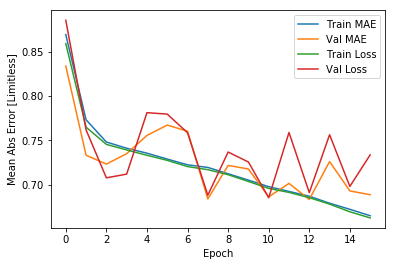


Testing set Mean Abs Error: 0.7066302514383209


In [8]:
# Don't worry, it will successfully overfit after those 16 epochs.
EPOCHS = 16

test_split_count = 233

# Split some test data out
new_train_data = train_data2[:-test_split_count];
new_div_data = div_data2[:-test_split_count];
new_train_labels = train_labels2[:-test_split_count];
test_data = train_data2[-test_split_count:];
test_div_data = div_data2[-test_split_count:];
test_labels = train_labels2[-test_split_count:];

# Store training stats
history = model.fit([new_train_data, new_div_data], new_train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, #batch_size=1,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

[loss, mae] = model.evaluate([test_data, test_div_data], test_labels, verbose=0)

print("\nTesting set Mean Abs Error: {}".format(mae))

test_predictions = model.predict([test_data, test_div_data]).reshape((-1, time_interval, train_labels.shape[1]))

# print(test_predictions)
# print(test_labels)
# print(test_predictions - list(test_labels))
# print("Mean Abs Error: "+str(np.mean(np.abs(test_predictions - test_labels))))

The result of this model looks pretty bad; it seems no better than random guessing.

Hmm.

In [9]:
from sklearn.metrics import f1_score

flat_test_preds = test_predictions.reshape(-1, train_labels2.shape[2]);
flat_test_labels = test_labels.reshape(-1, train_labels2.shape[2]);

pred_result = (np.sign(flat_test_preds) + 1) / 2
actual_result = (flat_test_labels + 1) / 2

prev_pred = np.concatenate([pred_result[-1:, 3], pred_result[:-1, 3]], axis=0);
this_pred = pred_result[:, 3];
another_slider_end_pred = np.max([this_pred * 0, this_pred - prev_pred], axis=0);
print("another_slider_end_prediction f1_score: {}".format(f1_score(another_slider_end_pred, actual_result[:, 1])))

random_result = (1 + np.sign(-1 + 2 * np.random.random(size=pred_result.shape))) / 2;
print(f1_score(actual_result.flatten(), pred_result.flatten()));
print(f1_score(actual_result.flatten(), random_result.flatten()));

# Individual column predictions
column_names = ["is_slider_start", "is_slider_end", "is_sliding", "is_sliding_incl_end"];
for i, k in enumerate(column_names):
    print("{} f1_score: {} from {}".format(k, f1_score(pred_result[:, i], actual_result[:, i]), f1_score(random_result[:, i], actual_result[:, i])))

another_slider_end_prediction f1_score: 0.11859443631039532
0.628901347168
0.437696335079
is_slider_start f1_score: 0.5305889079473985 from 0.29831775700934576
is_slider_end f1_score: 0.23890784982935157 from 0.2934823091247672
is_sliding f1_score: 0.572337962962963 from 0.48916064480266813
is_sliding_incl_end f1_score: 0.7768209544312882 from 0.5679963735267453


This is another model which takes 4 ticks of data starting from the slider tick, in order to figure out the length of the slider.

It's kind of... super overfitted...

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_90_input (Inpu (None, 4, 7, 32, 2)  0                                            
__________________________________________________________________________________________________
time_distributed_90 (TimeDistri (None, 4, 6, 31, 16) 144         time_distributed_90_input[0][0]  
__________________________________________________________________________________________________
time_distributed_91 (TimeDistri (None, 4, 6, 15, 16) 0           time_distributed_90[0][0]        
__________________________________________________________________________________________________
time_distributed_92 (TimeDistri (None, 4, 6, 15, 16) 0           time_distributed_91[0][0]        
__________________________________________________________________________________________________
time_distr

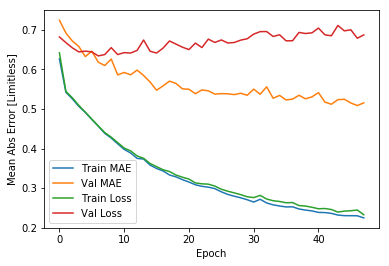


Testing set Mean Abs Error: 0.638661359001127


In [30]:
# Build another model.

def build_slider_model():
    model1 = keras.Sequential([
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 2),
                           data_format='channels_last'),
                           input_shape=(train_data_slider.shape[1], train_data_slider.shape[2], train_data_slider.shape[3], train_data_slider.shape[4])),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 3),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
#         keras.layers.LSTM(64, activation=tf.nn.tanh, return_sequences=False)
        keras.layers.Flatten()
    ])
    
    input2 = keras.layers.InputLayer(input_shape=(div_data.shape[1],));
    
    conc = keras.layers.concatenate([model1.output, input2.output]);
    dense1 = keras.layers.Dense(71, activation=tf.nn.tanh)(conc);
    dense2 = keras.layers.Dense(71, activation=tf.nn.relu)(dense1);
    dense3 = keras.layers.Dense(train_labels_slider.shape[1], activation=tf.nn.tanh)(dense2);
    

    optimizer = tf.train.RMSPropOptimizer(0.001);

    
    final_model = Model(inputs=[model1.input, input2.input], outputs=dense3);
    final_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return final_model

model_slider = build_slider_model()
model_slider.summary()

# and train it

EPOCHS_slider = 16

test_split_count_slider = 233

# Split some test data out
new_train_data_slider = train_data_slider[:-test_split_count_slider];
new_div_data_slider = div_data_slider[:-test_split_count_slider];
new_train_labels_slider = train_labels_slider[:-test_split_count_slider];
test_data_slider = train_data_slider[-test_split_count_slider:];
test_div_data_slider = div_data_slider[-test_split_count_slider:];
test_labels_slider = train_labels_slider[-test_split_count_slider:];

# Store training stats
history_slider = model_slider.fit([new_train_data_slider, new_div_data_slider], new_train_labels_slider, epochs=EPOCHS_slider,
                    validation_split=0.2, verbose=0, #batch_size=1,
                    callbacks=[early_stop, PrintDot()])

plot_history(history_slider)

[loss_slider, mae_slider] = model_slider.evaluate([test_data_slider, test_div_data_slider], test_labels_slider, verbose=0)

print("\nTesting set Mean Abs Error: {}".format(mae_slider))

test_predictions_slider = model_slider.predict([test_data_slider, test_div_data_slider]).reshape((-1, train_labels_slider.shape[1]))

In [31]:
flat_test_preds_slider = test_predictions_slider.reshape(-1, train_labels_slider2.shape[2]);
flat_test_labels_slider = test_labels_slider.reshape(-1, train_labels_slider2.shape[2]);

normalized_pred_results_slider = (flat_test_preds_slider - np.mean(flat_test_preds_slider, axis=0)) / np.std(flat_test_preds_slider, axis=0);

pred_argmax_slider = np.argmax(flat_test_preds_slider, axis=1);
pred_result_slider = np.array([[int(k==0), int(k==1), int(k==2), int(k==3)] for k in pred_argmax_slider]);
actual_result_slider = (flat_test_labels_slider + 1) / 2

random_result_slider = (1 + np.sign(-1 + 2 * np.random.random(size=pred_result_slider.shape))) / 2;
print(f1_score(actual_result_slider.flatten(), pred_result_slider.flatten()));
print(f1_score(actual_result_slider.flatten(), random_result_slider.flatten()));

# Individual column predictions
column_names = ["is_slider1", "is_slider2", "is_slider3", "is_slider4"];
for i, k in enumerate(column_names):
    print("{} f1_score: {} from {}".format(k, f1_score(pred_result_slider[:, i], actual_result_slider[:, i]), f1_score(random_result_slider[:, i], actual_result_slider[:, i])))

0.394849785408
0.340057636888
is_slider1 f1_score: 0.34146341463414637 from 0.22077922077922077
is_slider2 f1_score: 0.5555555555555555 from 0.4455445544554455
is_slider3 f1_score: 0.12121212121212123 from 0.3184713375796179
is_slider4 f1_score: 0.12121212121212119 from 0.3425414364640884


We still save the models since we took so much effort to build them. Even if we do not use them at all!

In [33]:
tf.keras.models.save_model(
    model,
    "saved_slider_model1",
    overwrite=True,
    include_optimizer=True
);
tf.keras.models.save_model(
    model_slider,
    "saved_slider_model2",
    overwrite=True,
    include_optimizer=True
);

# WARNING:tensorflow:TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer
# state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will
# have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
